# **Volatility Forecasting by LSTM_Workshop 1**


---



## **Introduction**
<p>The dataset  includes 28 assets from the Dow Jones Industrial Average (DJIA). It also includes an exchange-traded fund, SPY, that tracks the S&P 500 index. The data ranges from January 1, 2002, to August 31, 2008, and is made up of 1,640 samples. For each asset, data concerning the open-close returns and the realized volatility is available. The realized measure of volatility that we used is given by a realized kernel that was introduced by Barndorff-Nielsen et al. (2008). The realized kernel yields a more robust estimation of volatility even in the presence of noise. Also, it was implemented as proposed by Barndorff-Nielsen et al. (2011) to guarantee positive values.
<p>This dataset is available on Blackboard and in this book's repository at the following link: https:/ / github.
com/ PacktPublishing/ Hands- On- Deep- Learning- for- Finance. It can be loaded easily
using the pandas library.


**Step 1:** Import Libraries

In [1]:
# Import libraries
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import models


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Step 2:** (for Google colab users only)

In [2]:
#Drive mount:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Step 3 (for Tensorflow GPU users only, if you use CPU you can pass):**

In [2]:
# Set GPU device
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

**Step 4:** Define the data_folder variable as the path to the folder with the 28 datasets. Your path might be different from mine. 

In [7]:
# Variable definition
data_folder = 'C:/Users/kefanZ/Desktop/Handout Testing/DL in Finance 2020/Data/' # Folder containing the dataset
n_days = 1640

**Step 5:** Now, we will load the dataset step-by-step:

In [8]:
# Preallocate the array
dataset = np.empty((n_days, 0))

# Create list to save assets names
assets = []
for f in sorted(os.listdir(data_folder)):

    # Save assets names
    assets.append(f.replace('.csv', ''))

    # Load data
    asset = pd.read_csv(data_folder + f, sep=',', usecols=[2, 3], engine='python')
    asset = asset.values[:n_days]
 
    # Ensure all data is float
    asset = asset.astype('float32')
    dataset = np.append(dataset, asset, axis=1)

In [9]:
dataset[0].shape

(58,)

In [10]:
len(assets)

29

**Step 6:** Let’s now plot the returns and volatility related to the first assets in our dataset

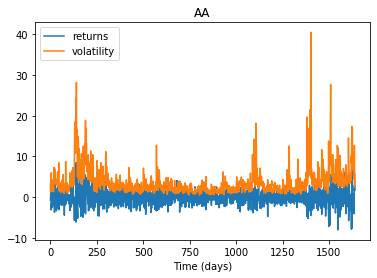

In [11]:
# Visualize returns and volatility of the first asset
i = 0
plt.plot(dataset[:, 0], label='returns')
plt.plot(dataset[:, 1], label='volatility')
plt.legend()
plt.title(assets[0])
plt.xlabel('Time (days)')
plt.show()

We can see from the preceding diagram how the volatility only takes positive values.

## **Data Preparation**

<p>Before defining and training the model, we need to prepare the dataset. This includes the
standardization of time series data, setting up a supervised learning problem, and splitting the data into training and testing datasets.
<p>Standardization consists of transforming a variable to have zero mean and unit variance by removing the mean and dividing it by the standard deviation. This process generates standard scores, which each represent the number of standard deviations that a specific observation is above or below the mean.
Since we expect the returns to have zero mean in the long term and the volatility to always be positive, we standardize both the returns and the volatilities by dividing them directly by the positive square root of the second raw moment.
<p>The raw moments are expressed by M_n=E[(X)^n ], where n is the corresponding order.
<p>The resulting values are then further divided by a factor of two to get at least 95% of samples within the range [-1,+1]. This is necessary when using the default hyperbolic tangent (tanh) activation function in the LSTM units to avoid saturation and the possible non-convergence of the model.


**Step 7:** The following code calculates the second raw moment for each input feature of the dataset and then scales the features, as explained previously:

In [12]:
# Normalize data
factor = 2

# Calculate second raw moment
M2 = np.mean(dataset ** 2, axis=0) ** (1/2)

# Apply scaling
dataset_norm = (1/factor) * (dataset / M2)

**Step 8:** The next step consists of transforming our dataset to get it ready for a supervised learning problem. We use a function that takes the dataset and the look-back as arguments and returns the input and target data for the LSTM model. The look-back is a hyperparameter that represents the number of previous time steps used to predict the next one. The function that we use creates sequences of a length that is equal to the look-back by moving one step ahead each time. These sequences correspond to the input data of the LSTM. It also associates each sequence with the observation at the next timestep, which represents the target of the model. The following code defines the function explained previously and applies it to our dataset by setting the look-back to 20 days, which is a common choice for this kind of analysis since 20 days are equivalent to one month. It is worth noting that we add to the target only the columns related to the volatility series, taking away those corresponding to the returns.
<p>Then, we define the variables representing the number of input features (n_features) and the number of considered assets (n_assets) that will be used later:


In [13]:
def create_dataset(dataset, look_back=1):
    """
    Function to convert series from dataset to supervised learning problem
    """
    data_x, data_y = [], []

    for i in range(len(dataset) - look_back):

        # Create sequence of length equal to look_back
        x = dataset[i:(i + look_back), :]
        data_x.append(x)

        # Take just the volatility for the target
        data_y.append(dataset[i + look_back, 1::2])

    return np.array(data_x), np.array(data_y)

In [14]:
# Convert series to supervised learning problem
look_back = 20
X, y = create_dataset(dataset_norm, look_back)

# Declare variables
n_features = dataset.shape[1]
n_assets = y.shape[1]

In [15]:
X.shape

(1620, 20, 58)

In [16]:
y.shape

(1620, 29)

**Step 9:** Finally, we split the dataset into the training set and the testing set. We will use the data that corresponds to the initial 300 days to fit the model, and then we will evaluate the trained model on the remaining days. The following code splits the dataset and then reshapes the input features so that they have the 3D tensor shape required by the LSTM:

In [17]:
# Split dataset
training_days = 300
X_train, X_test = X[:training_days], X[training_days:]
y_train, y_test = y[:training_days], y[training_days:]

# Prepare the 3D input vector for the LSTM
X_train = np.reshape(X_train, (-1, look_back, n_features))
X_test = np.reshape(X_test, (-1, look_back, n_features))

In [18]:
X_test.shape

(1320, 20, 58)

In [19]:
X_train.shape

(300, 20, 58)

##Creating and fitting the model
<p>As an input, the model takes the open-close returns and volatilities for a given past window. This is a sliding window containing past sequence values that have a fixed size expressed by the look_back hyperparameter. As an output, it provides the next one-step volatility, which is the volatility of the following day.
<p>The network consists of a first LSTM hidden layer made of 58 units and a fully connected (dense) output layer with 29 neurons, according to the input and output dimensions respectively. We use a stateful  LSTM, which can compute and keep the internal state along with the whole dataset.</p>

**Step 10:** We set the batch size to 1 since we will make one-step-ahead predictions on the testing set


In [20]:
batch_size = 1

# **Model 1 (Baseline Model):**

**Step 11:** Then, we define a sequential model by calling the .Sequential() method. After this, we
can add layers to the model via the .add() method:


In [21]:
# Create the model
model = Sequential()

**Step 12:** LSTM layers can be created using the Keras LSTM() class. The LSTM layer constructor takes as arguments the number of units and the input shape (input_shape=(timesteps,input_dim)) because it is the first layer of our network. A stateful LSTM requires tospecify the batch size since it keeps information from one batch to the next and then it isnecessary to know the position of the samples within the batch. To enable statefulness, we must specify stateful=True in the layer constructor:

In [22]:
model.add(LSTM(58,
               input_shape=(look_back, n_features),
               batch_size=batch_size,
               stateful=True,
               activity_regularizer=regularizers.l1_l2(),
               recurrent_regularizer=regularizers.l1_l2()))

**Step 13:** Regularization is important to deal with the undesired overfitting. We have included in the preceding implementation L1 and L2 regularization terms applied to the recurrent weights matrix (recurrent_regularizer) and the output (activity_regularizer) of the LSTM by using the regularizers.l1_l2() method. Then, we add a dropout layer to further reduce the overfitting. The Dropout() constructor takes as input the dropout rate, that is, the fraction of inputs set to 0 during training:

In [23]:
# add drop out:
model.add(Dropout(0.2))

**Step 14:** The arguments of the output dense layer are the number of units and the non-linear activation function. We use the sigmoid in this first example by setting activation='sigmoid':

In [24]:
#sigmoid:
model.add(Dense(n_assets, activation='sigmoid'))          

**Step 15:** The next step is to compile the model by using the .compile() method. We use the Mean
Square Error (MSE) as a loss function


In [25]:
# Compile the LSTM model
model.compile(loss='mse', optimizer='rmsprop')

**Step 16**: We are now ready to train the network by applying the .fit() method to the model. We use 300 epochs for fitting, which is not to be confused with the 300 training days! Training a stateful LSTM requires resetting the model state after each epoch by calling .reset_states(). We can do this inside a loop by setting the hyperparameter of the epoch to 1. A stateful LSTM also requires us to specify shuffle=False when calling .fit() since it is important to preserve the temporal order of the samples. The batch_size hyperparameter is needed to indicate the number of samples required for the gradient update.

In [26]:
num_epochs = 300

# Fit the model
for i in range(num_epochs):

    model.fit(X_train,
              y_train,
              batch_size=batch_size,
              shuffle=False,
              epochs=1,
              verbose=0) # Verbosity mode 0: silent

    model.reset_states()

After a few minutes, our model will be trained. Please be patient with the training process since we are training 300 epochs, and with CPU it can take a long time. Once we have our LSTM model trained, it's time to evaluate it. How will it perform with new, unseen data?

## Evaluating the model
**Step 17:** After training our model, we can now make predictions on the test dataset for an out-of sample evaluation. We apply a rolling forecast window to forecast the volatility every time one-step-ahead, using the new available information to predict the volatility of the next day, as we may often want to do in real life. Predictions in Keras are made using the .predict() method, which takes the test set and the batch size as input.
<p>The following code makes the predictions on our test dataset, as explained previously:


In [27]:
# Make a prediction (rolling test window)
y_pred = np.empty((0, n_assets))

for i in range(len(X_test)):
    X_i = X_test[i].reshape(1, look_back, n_features)
    predicted_output = model.predict(X_i, batch_size=batch_size)

    # Reshape prediction to save into array
    predicted_output = predicted_output.reshape(1, n_assets)
    y_pred = np.append(y_pred, predicted_output, axis=0)

y_pred = y_pred.reshape(-1, n_assets)
y_true = y_test.reshape(-1, n_assets)

**Step 18:** Before calculating the error scores, we need to invert the standardization applied during the data preparation step to return the time series to their original scale. Remember that we now only have to revert the transformation on the volatility series, which is our target.
<p>Hence, we modify the M2 variable to preserve the volatility moments and take away those corresponding to the open-close returns. We create a function to carry out this transformation, the arguments of which are the array to rescale, the moment array, and the multiplicative factor of the moment, as shown in the following code:


In [25]:
# Invert scaling
def invert_standardization(data, M2, factor):  
    # Consider just volatility series
    M2 = M2[1::2]
    data = factor * data * M2
    return data

# Apply inversion
y_pred0 = invert_standardization(y_pred, M2, factor)
y_true0 = invert_standardization(y_true, M2, factor)

**Step 19:** The following code defines a function to calculate the preceding measures with respect to the predicted and expected volatilities. This function returns the average for each stock in the dataset and saves the results point by point into a CSV file for further comparison. We can save the results by using the .savetxt() function from the NumPy library:

In [29]:
def evaluate(y_true, y_pred):
    """
    Function to calculate MSE and QLIKE
    """
    mse = []
    qlike = []
    for i in range(0, 29):
        mse_i = (y_true[:, i] - y_pred[:, i]) ** 2
        qlike_i = np.log(y_pred[:, i]) + (y_true[:, i] /  y_pred[:, i])
        # save results (point by point)
        #results = np.array([mse_i, qlike_i]).transpose()
        #np.savetxt(folder + assets[i] + '.csv', results, delimiter=',', header='MSE, Q-LIKE', fmt='%10.5f', comments='')
        mse.append(np.mean(mse_i, axis=0))
        qlike.append(np.mean(qlike_i, axis=0))
    return mse, qlike

**Step 19 (Optional)**: 
Use this code for step 19 instead of the previous version to save the code point by point into the folder:


```
def evaluate(y_true, y_pred):
    """
    Function to calculate MSE and QLIKE
    """
    mse = []
    qlike = []
    for i in range(0, 29):
        mse_i = (y_true[:, i] - y_pred[:, i]) ** 2
        qlike_i = np.log(y_pred[:, i]) + (y_true[:, i] /  y_pred[:, i])
        # save results (point by point)
        results = np.array([mse_i, qlike_i]).transpose()
        np.savetxt(folder + assets[i] + '.csv', results, delimiter=',', header='MSE, Q-LIKE', fmt='%10.5f', comments='')
        mse.append(np.mean(mse_i, axis=0))
        qlike.append(np.mean(qlike_i, axis=0))
    return mse, qlike
#Execute the function:
evaluate(y_true, y_pred, '/content/drive/My Drive/Chapter 5/1Base/')
```

**Step 20:** We can now have a look at the results of our experiment. We can summarize them using the .describe() function from pandas. This provides descriptive statistics that summarize the central tendency, dispersion, and shape of the distribution of our dataset.
<p>This is done by using the following code:


In [30]:
# Apply EVALUATE function to predictions
mse0, qlike0 = evaluate(y_true0, y_pred0)

# save results
# results = np.array([mse, qlike]).transpose()
# np.savetxt(save_folder, results, delimiter=',', header='MSE,Q-LIKE', fmt='%10.5f', comments='')

df = pd.DataFrame({'MSE': mse0, 'QLIKE': qlike0})
print(df.describe())

NameError: name 'y_true0' is not defined

**Step 20 (Optional)**: Use this code if you want to save your files into a folder

```
save_folder='/content/drive/My Drive/Chapter 5/Result/1.csv'
# Apply EVALUATE function to predictions

mse0, qlike0 = evaluate(y_true0, y_pred0)

# save results
results = np.array([mse, qlike]).transpose()
np.savetxt(save_folder, results, delimiter=',', header='MSE,Q-LIKE', fmt='%10.5f', comments='')

df = pd.DataFrame({'MSE': mse0, 'QLIKE': qlike0})
print(df.describe())

```



The MSE is too high and is not consistent between the different stocks, as shown by its higher standard deviation in the summary. However, the QLIKE seems to be a more stable measure.